# Imports/Paths

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.set_device(0)

In [4]:
path = Path() ; path.ls()

[PosixPath('Util_resize.ipynb'),
 PosixPath('Sketch - GAN.ipynb'),
 PosixPath('to_predict'),
 PosixPath('dataset'),
 PosixPath('Util.ipynb'),
 PosixPath('.ipynb_checkpoints'),
 PosixPath('cyclegan_s2b.ipynb')]

In [5]:
inp_dir = path/'dataset/input'
targ_dir = path/'dataset/output'

In [6]:
saved_model = path/'dataset/Model-1.pth'
saved_model.exists()

True

In [7]:
saved_model

PosixPath('dataset/Model-1.pth')

# Feature Loss

In [8]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x@x.transpose(1,2))/(c*h*w)

In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]

In [10]:
base_loss = F.l1_loss

In [11]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
        

In [12]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Databunch

In [13]:
learn = None
gc.collect()

204

In [23]:
#bs, size = 7, 512
bs, size = 16, 256
arch = models.resnet34
# sample = .1
sample = None

In [24]:
src = ImageImageList.from_folder(inp_dir).split_by_folder(train='train', valid='valid'); src

ItemLists;

Train: ImageImageList (1859 items)
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/input;

Valid: ImageImageList (10 items)
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
Path: dataset/input;

Test: None

In [25]:
tfms = get_transforms(do_flip=True, flip_vert=False, 
                      max_rotate=0.0, max_zoom=1.1, 
                      max_lighting=0.3, max_warp=0.1, 
                      p_affine=0.75, p_lighting=0.75)

In [26]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: targ_dir/x.relative_to(inp_dir))
            .transform(tfms, size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [27]:
data = get_data(bs, size)

In [ ]:
data.show_batch(rows=4, figsize=(17,17))

## Learner

In [29]:
learn = unet_learner( data, arch,  
                    loss_func = feat_loss,
                    callback_fns = LossMetrics,
                    blur = True,
                    norm_type = NormType.Weight
                    )
gc.collect()

16947

## Freezed train

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


In [20]:
learn.fit_one_cycle(20, 1e-2, wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t1')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,3.120044,3.104301,0.949980,0.255786,0.302793,0.094187,0.517860,0.889195,0.094499,01:06
1,2.796091,2.826647,0.744552,0.250491,0.298704,0.094847,0.506432,0.837168,0.094452,01:03
2,2.628471,2.744904,0.742642,0.240369,0.291393,0.092383,0.464953,0.822272,0.090891,01:03
3,2.591088,2.560423,0.633128,0.237436,0.287725,0.089423,0.428233,0.796382,0.088096,01:03
4,2.508297,2.775897,0.763831,0.243822,0.294320,0.090989,0.464130,0.827535,0.091269,01:03
5,2.476996,2.424245,0.606918,0.229174,0.271846,0.084320,0.401710,0.745535,0.084742,01:03
6,2.440335,2.589657,0.727574,0.223828,0.271150,0.084886,0.421294,0.775835,0.085089,01:02
7,2.364450,2.422199,0.574051,0.228056,0.271921,0.086108,0.408752,0.766934,0.086377,01:03
8,2.307764,2.463181,0.647883,0.229116,0.267914,0.082399,0.401755,0.750461,0.083652,01:03
9,2.266996,2.407435,0.661506,0.219324,0.260051,0.081311,0.389091,0.713261,0.082891,01:02


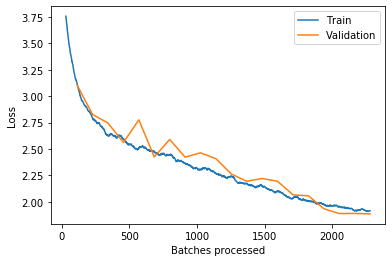

In [21]:
learn.recorder.plot_losses(skip_start=30)

In [ ]:
learn.show_results(rows=4, imgsize=10)

## Unfreeze tranning

In [46]:
learn.load('T1_18')
print()

In [28]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


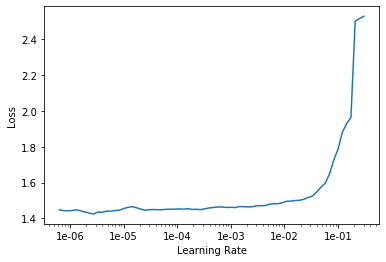

In [48]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.fit_one_cycle(10, slice(1e-6, 1e-3), wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t2')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.919564,1.870444,0.437729,0.205771,0.230617,0.075201,0.315070,0.528185,0.077872,01:05
1,1.929044,1.897111,0.443808,0.206671,0.232718,0.075754,0.316012,0.543887,0.078261,01:05
2,1.927377,1.915676,0.439973,0.205388,0.232284,0.074843,0.319998,0.565690,0.077500,01:05
3,1.918466,1.921043,0.451622,0.205758,0.231732,0.074983,0.322540,0.556998,0.077410,01:05
4,1.908162,1.822003,0.437625,0.203759,0.227395,0.074521,0.311740,0.489538,0.077426,01:05
5,1.896195,1.833643,0.431796,0.204845,0.228209,0.074267,0.311377,0.506027,0.077123,01:05
6,1.857955,1.804553,0.425794,0.204051,0.226491,0.074229,0.309918,0.486979,0.077091,01:05
7,1.857404,1.800415,0.424374,0.203404,0.226541,0.074015,0.309491,0.485701,0.076889,01:05
8,1.835808,1.786519,0.420916,0.203509,0.225457,0.073985,0.307402,0.478352,0.076896,01:05
9,1.833147,1.785136,0.423364,0.204683,0.226136,0.074299,0.305515,0.473857,0.077282,01:05


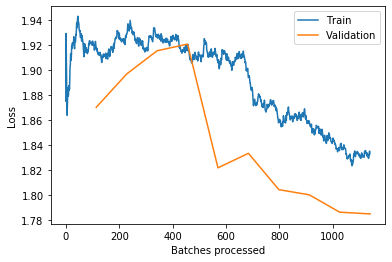

In [25]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results(rows=4, imgsize=10)

In [27]:
learn.save('Model-1')

In [24]:
learn.fit_one_cycle(10, slice(1e-6, 1e-3), wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t3')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.919564,1.870444,0.437729,0.205771,0.230617,0.075201,0.315070,0.528185,0.077872,01:05
1,1.929044,1.897111,0.443808,0.206671,0.232718,0.075754,0.316012,0.543887,0.078261,01:05
2,1.927377,1.915676,0.439973,0.205388,0.232284,0.074843,0.319998,0.565690,0.077500,01:05
3,1.918466,1.921043,0.451622,0.205758,0.231732,0.074983,0.322540,0.556998,0.077410,01:05
4,1.908162,1.822003,0.437625,0.203759,0.227395,0.074521,0.311740,0.489538,0.077426,01:05
5,1.896195,1.833643,0.431796,0.204845,0.228209,0.074267,0.311377,0.506027,0.077123,01:05
6,1.857955,1.804553,0.425794,0.204051,0.226491,0.074229,0.309918,0.486979,0.077091,01:05
7,1.857404,1.800415,0.424374,0.203404,0.226541,0.074015,0.309491,0.485701,0.076889,01:05
8,1.835808,1.786519,0.420916,0.203509,0.225457,0.073985,0.307402,0.478352,0.076896,01:05
9,1.833147,1.785136,0.423364,0.204683,0.226136,0.074299,0.305515,0.473857,0.077282,01:05


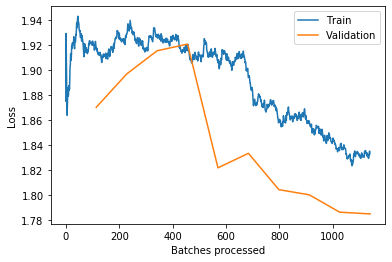

In [25]:
learn.recorder.plot_losses()

In [ ]:
learn.show_results(rows=4, imgsize=10)

# Train size 512

In [21]:
learn.load('Model-1')
print()

In [22]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


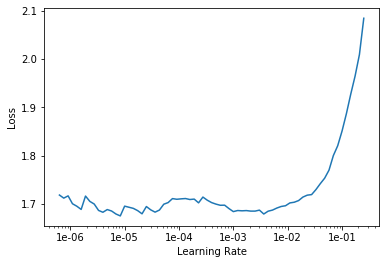

In [23]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(1, 3e-3, wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t3')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.625802,1.274598,0.379668,0.182848,0.183140,0.047552,0.200375,0.250020,0.030996,05:05


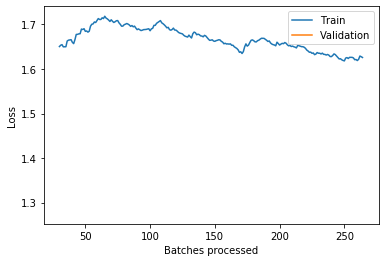

In [23]:
learn.recorder.plot_losses(skip_start=30)

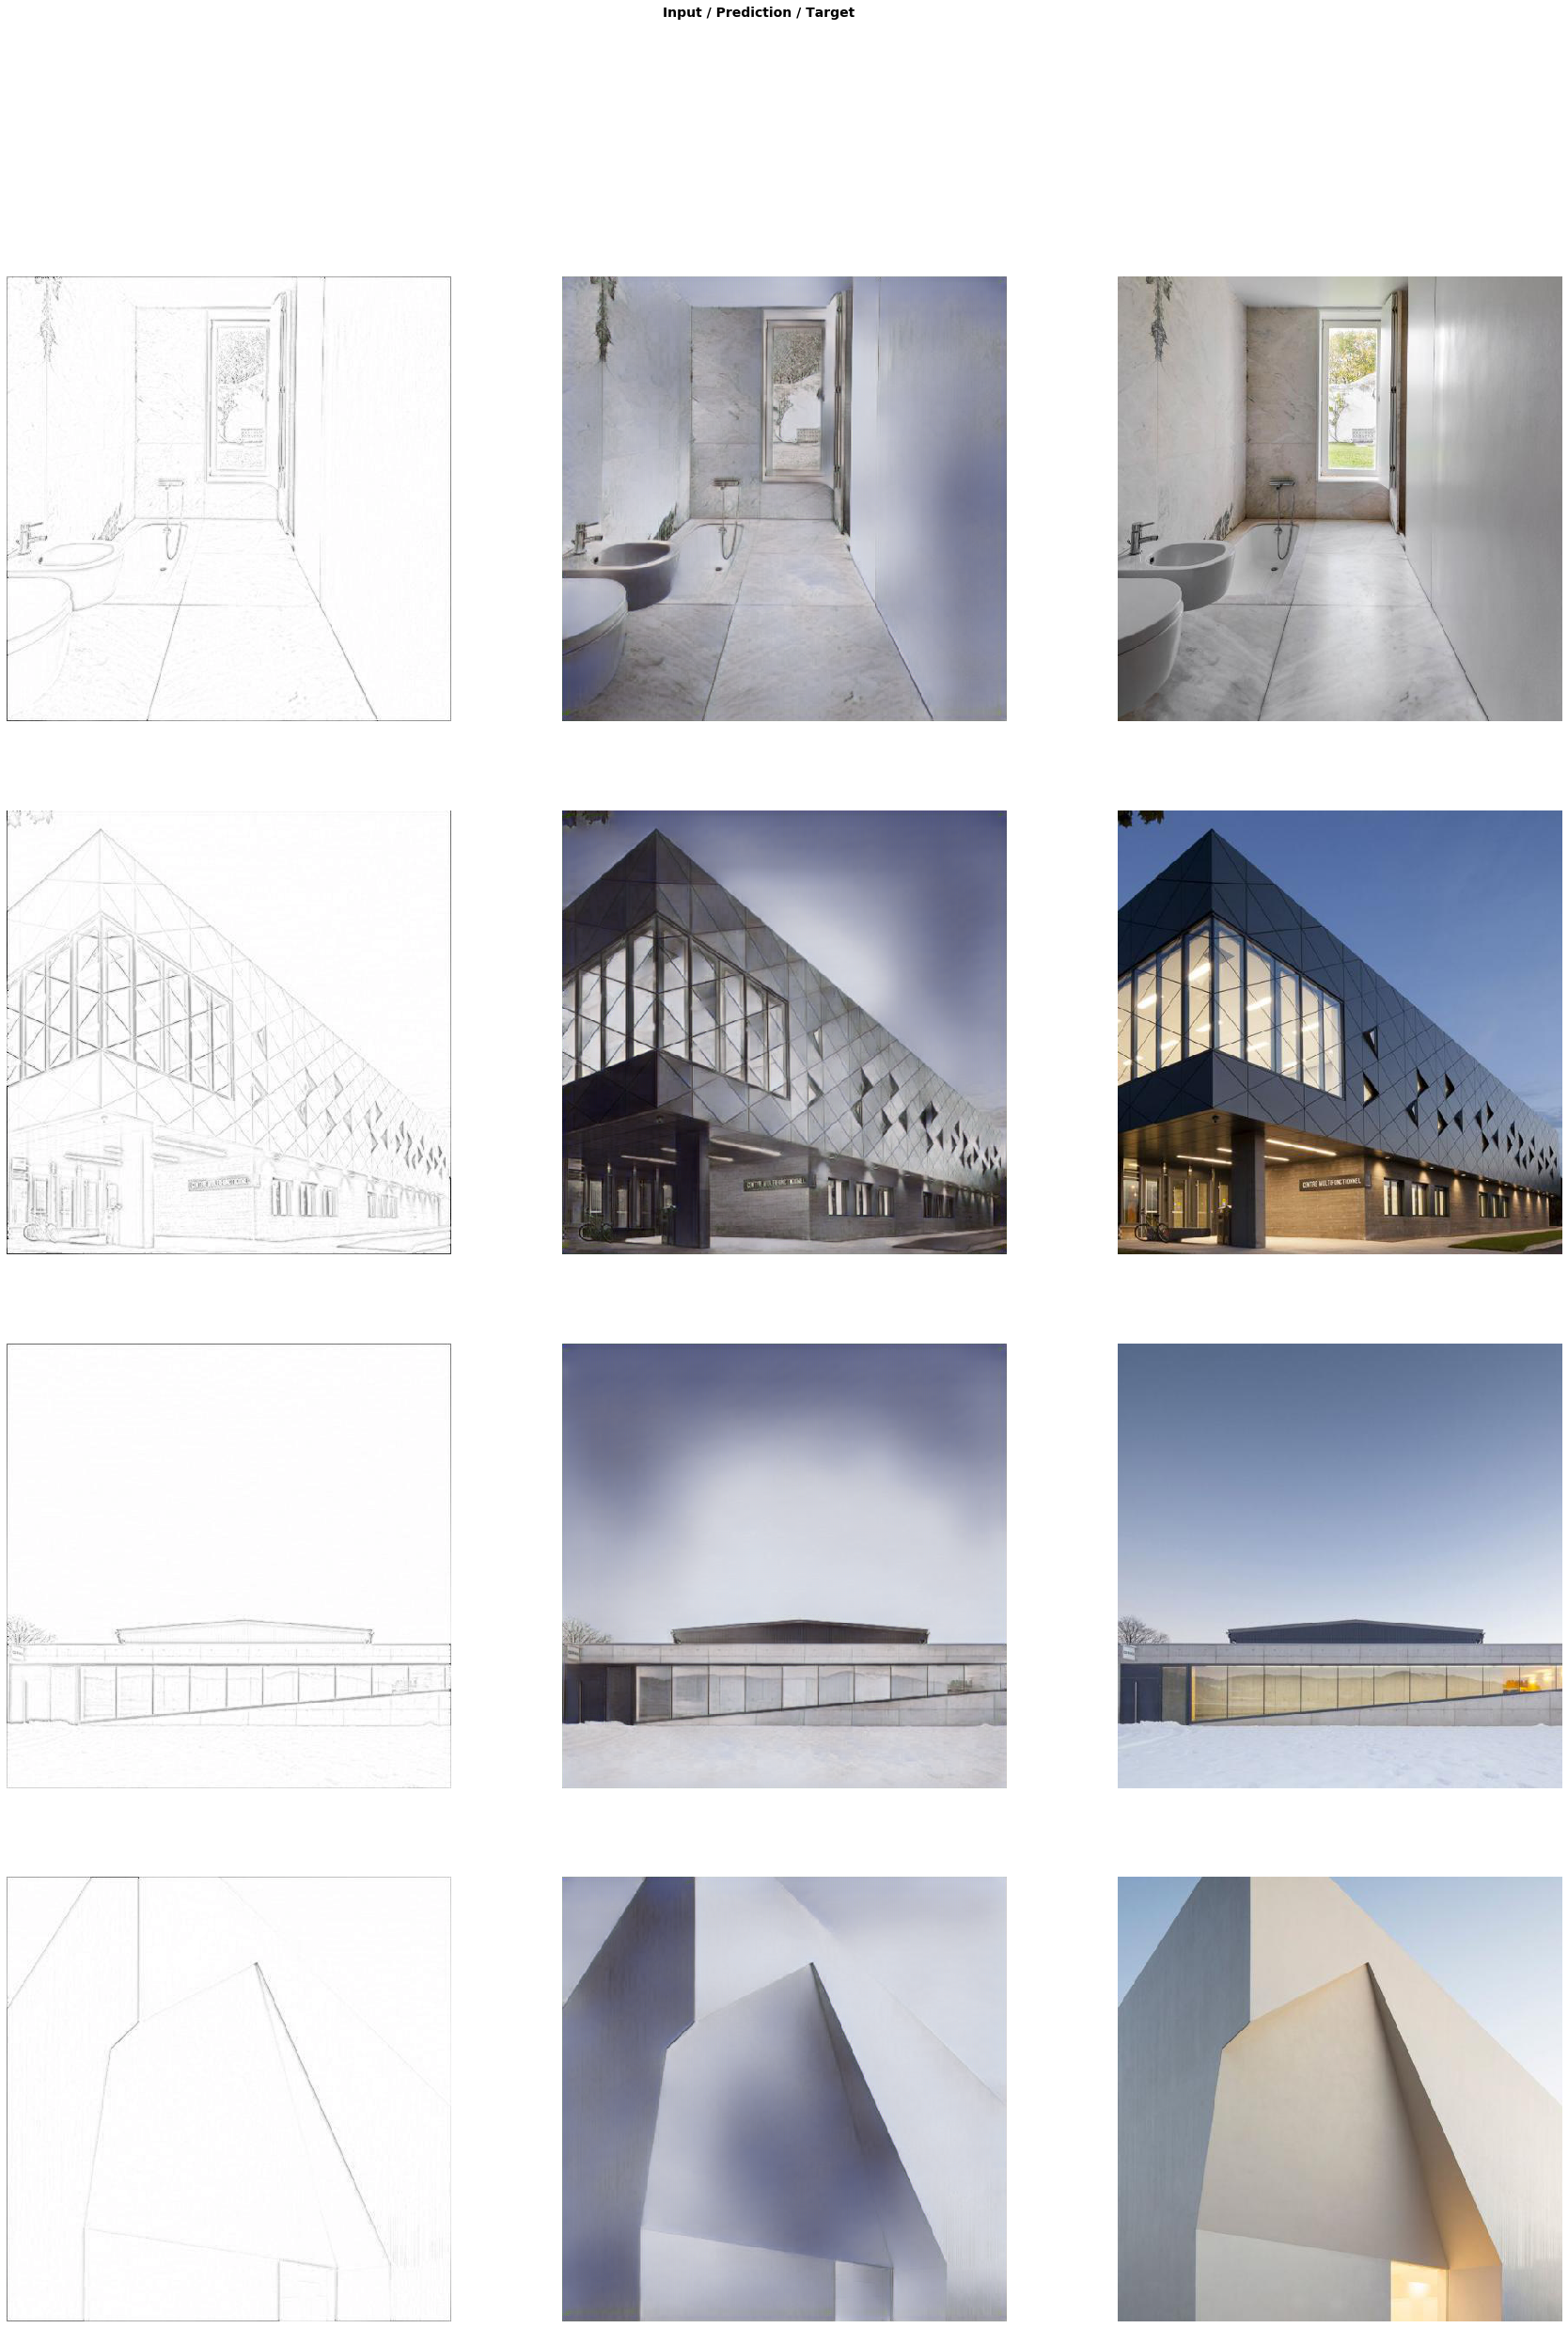

In [24]:
learn.show_results(rows=4, imgsize=10)

In [25]:
learn.unfreeze()

In [26]:
learn.fit_one_cycle(1, slice(1e-6,3e-3), wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t4')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,1.634046,1.307071,0.393179,0.181884,0.183240,0.047452,0.209672,0.260771,0.030873,05:00


In [27]:
learn.save('Model-2')

In [28]:
learn.export(path/'Model-2.pkl')

# Train on Threshold images

In [36]:
learn.load('Model-2')
print()

In [37]:
learn.freeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


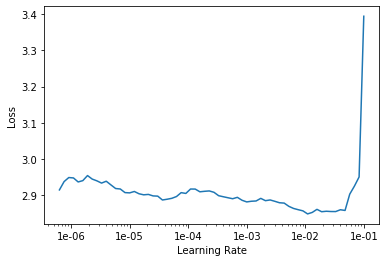

In [32]:
learn.lr_find()
learn.recorder.plot()

In [38]:
learn.fit_one_cycle(10, 4e-3, wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t4')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.691824,2.461401,0.641806,0.263278,0.294804,0.084448,0.485480,0.615131,0.076452,01:04
1,2.614868,2.337024,0.553839,0.262332,0.294686,0.080840,0.458607,0.613662,0.073057,01:04
2,2.572022,2.289427,0.538001,0.255513,0.287506,0.078999,0.448129,0.609134,0.072145,01:04
3,2.537359,2.265324,0.560141,0.257854,0.284924,0.078626,0.435774,0.576394,0.071610,01:04
4,2.486224,2.273573,0.591199,0.255289,0.281037,0.078667,0.419528,0.575883,0.071968,01:04
5,2.429617,2.168561,0.513569,0.253622,0.280085,0.077637,0.401611,0.571835,0.070200,01:04
6,2.397685,2.133165,0.497817,0.251944,0.277157,0.077508,0.398987,0.559024,0.070728,01:04
7,2.351404,2.087922,0.505305,0.252889,0.274677,0.077352,0.377813,0.529062,0.070825,01:04
8,2.328955,2.069118,0.490376,0.252824,0.273858,0.077390,0.375799,0.528546,0.070326,01:04
9,2.309702,2.081627,0.503621,0.252474,0.273437,0.076853,0.378170,0.526799,0.070273,01:04


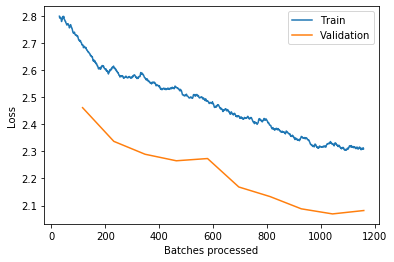

In [40]:
learn.recorder.plot_losses(skip_start=30)

In [ ]:
learn.show_results(rows=4, imgsize=10)

In [43]:
learn.unfreeze()

In [44]:
learn.fit_one_cycle(5, slice(1e-6,3e-3), wd=1e-3, callbacks=[SaveModelCallback(learn, every='epoch', name='unet-t5')])


epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,2.338574,2.076669,0.480196,0.250639,0.274044,0.076837,0.387232,0.537331,0.070390,01:06
1,2.366546,2.080716,0.477703,0.253759,0.274612,0.077102,0.382064,0.545707,0.069769,01:06
2,2.351313,2.114886,0.494028,0.251163,0.274502,0.076264,0.377229,0.571365,0.070335,01:06
3,2.296369,1.995990,0.456962,0.250770,0.269231,0.075680,0.362818,0.510813,0.069716,01:06
4,2.254089,2.003127,0.459223,0.250773,0.268680,0.074890,0.365828,0.514889,0.068844,01:06


In [45]:
learn.save('Model-3')

In [46]:
learn.export(path/'Model-3.pkl')

In [ ]:
learn.show_results(rows=10, imgsize=10)

# Predict

## Feat loss CPU

In [6]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x@x.transpose(1,2))/(c*h*w)

In [9]:
vgg_m = vgg16_bn(True).features.eval()#.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]

In [10]:
base_loss = F.l1_loss

In [11]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()
        

In [12]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Learner

In [50]:
tp = (path/'to_predict').ls()

In [51]:
len(tp)

26

In [13]:
learn = load_learner(path/'dataset/input', 'Model-2.pkl')

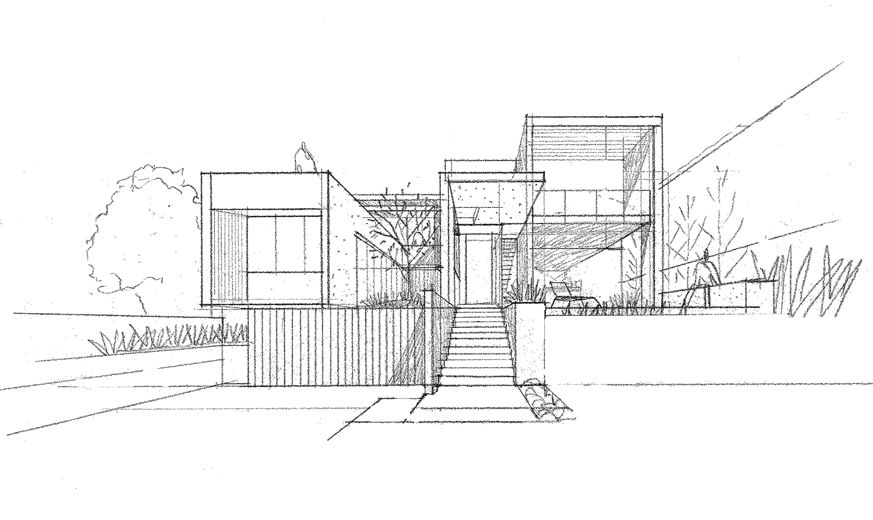

In [69]:
img = open_image(tp[21]); img

In [70]:
pred = learn.predict(img)

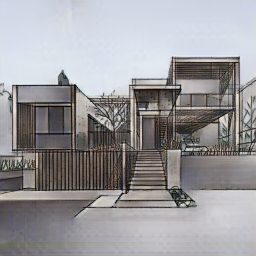

In [71]:
pred[0]